### CNNMLP Implementation
- Based on [Joo et al., 2023](https://www.nature.com/articles/s41598-023-49514-2#)

In [ ]:
import sys, warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import torch, gc
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchinfo import summary

from pyprojroot import here

sys.path.insert(0, f"{here()}/src")

from cnn_classifier import CNNMLP
from dataset import MRIDataset
from train import train_classifiermodel

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)
pd.reset_option("mode.chained_assignment")

PyTorch version: 2.7.1+cu128
torchvision version: 0.22.1+cu128


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
gc.collect()
torch.cuda.empty_cache()

In [4]:
!nvidia-smi

Wed Aug  6 15:09:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.64.03              Driver Version: 575.64.03      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5090        Off |   00000000:01:00.0  On |                  N/A |
| 30%   36C    P5             62W /  575W |    9004MiB /  32607MiB |     24%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
proj_dir = here()

In [6]:
model = CNNMLP(input_shape=1, flattened_dim=18432).to(device)

In [7]:
summary(model)

Layer (type:depth-idx)                   Param #
CNNMLP                                   --
├─Sequential: 1-1                        --
│    └─Conv3d: 2-1                       896
│    └─BatchNorm3d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool3d: 2-4                    --
│    └─Conv3d: 2-5                       55,360
│    └─BatchNorm3d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool3d: 2-8                    --
│    └─Conv3d: 2-9                       221,312
│    └─BatchNorm3d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─MaxPool3d: 2-12                   --
│    └─Conv3d: 2-13                      884,992
│    └─BatchNorm3d: 2-14                 512
│    └─ReLU: 2-15                        --
│    └─MaxPool3d: 2-16                   --
│    └─Conv3d: 2-17                      3,539,456
│    └─BatchNorm3d: 2-18                 1,024
│    └─ReLU: 2-19                        --

In [8]:
#neuralnet = NeuralNetwork(input_shape=1, hidden_units=32).to(device)

In [9]:
#summary(model=neuralnet)

#### Load Training Data

In [10]:
train_data_directory = "/home/murage/Documents/data/train/" #"/home/Murage/BrainAgefMRI/data/mri/"
validation_data_directory = "/home/murage/Documents/data/validation/" 
pheno_directory = "/home/murage/Documents/data/mri_phenotype_partitioned.csv" #"/shared/uher/Murage/BrainAgefMRI/data/mri_phenotype_partitioned.csv" 

In [11]:
df = pd.read_csv(pheno_directory)
df['filename'] = df['filename'] + '.gz'
df['filename'] = df['filename'].str.strip()

#### Create classes for classification

In [12]:
df.scan_age.describe()

count    2882.000000
mean       15.427754
std         5.778837
min         3.250000
25%        10.632603
50%        14.888227
75%        20.000000
max        30.000000
Name: scan_age, dtype: float64

In [13]:
# Create 3-year age brackets from 3 to 30
bins = list(range(3, 31, 3)) + [31]  # [5, 8, 11, ..., 29, 31]
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df['age_bracket'] = pd.cut(df['scan_age'], bins=bins, labels=labels, right=False, include_lowest=True)

In [14]:
df['age_bracket_class'] = df['age_bracket'].cat.codes

In [15]:
df['age_bracket_class'].describe()

count    2882.000000
mean        3.699167
std         1.975218
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max         9.000000
Name: age_bracket_class, dtype: float64

In [16]:
df['age_bracket'].value_counts()

age_bracket
9-11     597
18-20    507
12-14    481
21-23    368
15-17    326
6-8      304
24-26    138
27-29     76
3-5       74
30-30     11
Name: count, dtype: int64

In [17]:
df[['age_bracket', 'age_bracket_class', 'scan_age']].sample(5)

,age_bracket,age_bracket_class,scan_age
2318,6-8,1,7.333333
497,12-14,3,14.425000
1062,18-20,5,19.000000
51,9-11,2,9.961898
2485,21-23,6,22.000000


In [18]:
df.sample(5)

,scan_id,dataset,sex,scan_age,filename,scan_id_,project,split,age_bracket,age_bracket_class
519,0051136,ABIDE,Male,12.660000,ABIDE-Trinity-sub-0051136.nii.gz,ABIDE-Trinity-sub-0051136,ABIDE,TRAINING,12-14,3
429,0050428,ABIDE,Male,15.500000,ABIDE-UM2-sub-0050428.nii.gz,ABIDE-UM2-sub-0050428,ABIDE,TRAINING,15-17,4
2543,0025843,CORR,Female,21.000000,CORR-SWU4-sub-0025843.nii.gz,CORR-SWU4-sub-0025843,CORR,TRAINING,21-23,6
1793,28842,ABIDE II,Male,8.408219,ABIDE2-GU1-sub-28842.nii.gz,ABIDE2-GU1-sub-28842,ABIDE2,TRAINING,6-8,1
1982,P0863,PING,Male,20.750000,PING-sub-P0863.nii.gz,PING-sub-P0863,PING,TRAINING,18-20,5


In [19]:
# Save train and validation filenames into list
train = df[df['split'] == 'TRAINING']
validation = df[df['split'] == 'VALIDATE']
train_ids = train['filename'].to_list()
validation_ids = validation['filename'].to_list()

print(f" Train N: {len(train_ids)} | Validation N: {len(validation_ids)}") 

 Train N: 2312 | Validation N: 570


In [20]:
!ls /home/murage/Documents/data/train/ | wc -l

2312


In [21]:
!ls /home/murage/Documents/data/validation/ | wc -l

570


In [22]:
train = train[['filename', 'scan_age', 'sex', 'age_bracket_class', 'project']]
validation = validation[['filename', 'scan_age', 'sex', 'age_bracket_class', 'project']]

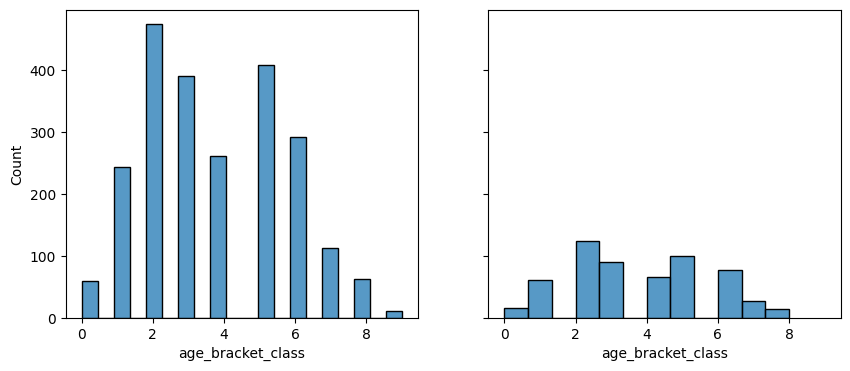

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
sns.histplot(train['age_bracket_class'], ax=ax1)
sns.histplot(validation['age_bracket_class'], ax=ax2)
plt.show()

In [24]:
train.sample()

,filename,scan_age,sex,age_bracket_class,project
2407,CORR-BNU1-sub-0025898.nii.gz,22.0,Female,6,CORR


In [25]:
train.age_bracket_class.value_counts()

age_bracket_class
2    474
5    408
3    391
6    291
4    261
1    243
7    112
8     62
0     59
9     11
Name: count, dtype: int64

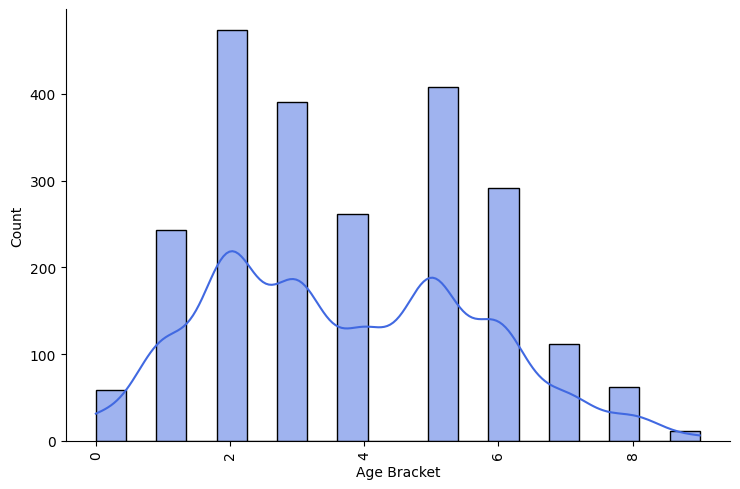

In [26]:
g = sns.displot(
    train['age_bracket_class'],
    kde=True,
    color="royalblue",
    height=5,
    aspect=1.5
)
g.set_axis_labels("Age Bracket", "Count")
plt.xticks(rotation=90)
#plt.title("Chronological Age")
plt.tight_layout()
plt.show()

#### Balance classes in each batch

In [27]:
class_counts = np.bincount(train['age_bracket_class'])
class_weights = 1. / class_counts
sample_weights = [class_weights[c] for c in train['age_bracket_class']]

In [28]:

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [29]:
len(sample_weights)

2312

#### Train DataLoader

In [30]:
train_dataset = MRIDataset(df=train, id_col='filename', agebracket='age_bracket_class', target_col='scan_age', root_dir=train_data_directory)
validation_dataset = MRIDataset(df=validation, id_col='filename', agebracket='age_bracket_class', target_col='scan_age', root_dir=validation_data_directory)

In [31]:
for i in range(5):
    try:
        image, agebracket, label = train_dataset[i]
        print(f"Index: {i}, {agebracket}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
    except KeyError:
        print(f"Index: {i}, {agebracket}, Image shape: {image.shape if hasattr(image, 'shape') else type(image)}, Label: {label}")
        #print(f"Index {i}: not found")

Index: 0, 2, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([9.4884])
Index: 1, 2, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([11.8236])
Index: 2, 4, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([16.4967])
Index: 3, 3, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([13.4637])
Index: 4, 3, Image shape: torch.Size([1, 121, 145, 121]), Label: tensor([12.9977])


In [32]:
train_dataloader = DataLoader(train_dataset, batch_size=4, sampler=sampler, pin_memory=True) #shuffle=True,
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
#cnnmodel, tracking_loss = train_and_select_best_model(model=model, train_dataloader=train_dataloader, 
#                    validation_dataloader=validation_dataloader, optimizer=optimizer, loss=mae, device=device, num_epochs=20, name='cnn')

In [35]:
image, agebracket, label = next(iter(train_dataloader))
print(f'{image.shape}, {agebracket}: {label}')

torch.Size([4, 1, 121, 145, 121]), tensor([0, 2, 4, 1], dtype=torch.int8): tensor([[ 5.2500],
        [11.5500],
        [15.4017],
        [ 6.4167]])


In [36]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / y_true.size(0)) * 100 
    return acc


In [37]:
num_epochs=15
model, tracking_loss, tracking_val_loss = train_classifiermodel(
    model=model, train_dataloader=train_dataloader, validation_dataloader=validation_dataloader, optimizer=optimizer,
    device=device, num_epochs=num_epochs, name='cnmlp'
)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15:
 -----------
Train loss (acc): 6.98 (9.99%) | l2: 2.31
Val Loss (acc): 15.30, (20.98%) | l2: 2.28 
Model saved with validation MAE: 15.3044, accuracy: 20.9790% 
Epoch 2/15:
 -----------
Train loss (acc): 6.13 (9.90%) | l2: 2.31
Val Loss (acc): 3.89, (20.45%) | l2: 2.29 
Model saved with validation MAE: 3.8898, accuracy: 20.4545% 
Epoch 3/15:
 -----------
Train loss (acc): 6.03 (9.13%) | l2: 2.31
Val Loss (acc): 8.90, (18.53%) | l2: 2.29 
Epoch 4/15:
 -----------
Train loss (acc): 5.41 (9.13%) | l2: 2.31
Val Loss (acc): 2.92, (14.69%) | l2: 2.29 
Model saved with validation MAE: 2.9239, accuracy: 14.6853% 
Epoch 5/15:
 -----------
Train loss (acc): 5.34 (10.21%) | l2: 2.31
Val Loss (acc): 6.28, (8.57%) | l2: 2.29 
Epoch 6/15:
 -----------
Train loss (acc): 5.11 (9.30%) | l2: 2.31
Val Loss (acc): 11.22, (16.96%) | l2: 2.30 
Epoch 7/15:
 -----------
Train loss (acc): 4.93 (11.20%) | l2: 2.30
Val Loss (acc): 7.39, (13.81%) | l2: 2.29 
Epoch 8/15:
 -----------
Train loss (acc): 

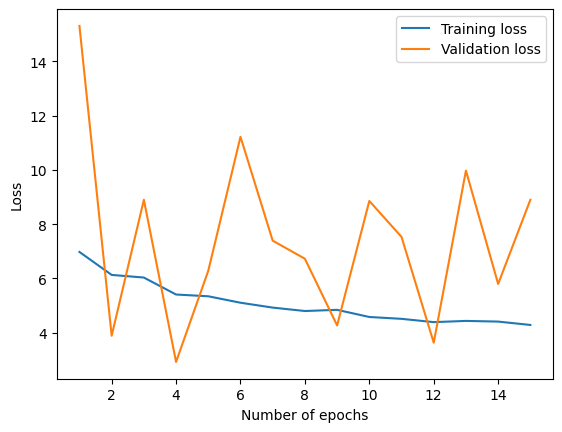

In [38]:
plt.plot(range(1, num_epochs + 1), tracking_loss, label="Training loss")
plt.plot(range(1, num_epochs + 1), tracking_val_loss, label="Validation loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend(loc = "upper right")
plt.show()